## Installation of Requisite Libraries

In [1]:
#pip install openpyxl

In [2]:
#pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
from datetime import timedelta

## Data Import and Preliminary Examination

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
df = pd.read_excel('/Users/alam_n/Documents/Python/Creators_case_study_sample_data.xlsx')

df.head(10)


,CID,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,...,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,At risk,type of payment
0,1,Male,0,No,No,34,Yes,No,Hulu Music,Yes,...,Yes,No,No,No,One year,No,56.95,1889.50,No,courier check
1,2,Male,0,No,No,2,Yes,No,Hulu Music,Yes,...,No,No,No,No,Month-to-month,Yes,53.85,108.15,Yes,courier check
2,3,Female,0,No,No,2,Yes,No,Yotube Music,No,...,No,No,No,No,Month-to-month,Yes,70.70,151.65,Yes,echeck
3,4,Female,0,No,No,8,Yes,Yes,Yotube Music,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,99.65,820.50,Yes,echeck
4,5,Male,0,No,Yes,22,Yes,Yes,Yotube Music,No,...,No,No,Yes,No,Month-to-month,Yes,89.10,1949.40,No,cc
5,6,Female,0,No,No,10,No,No Youtube TV,Hulu Music,Yes,...,No,No,No,No,Month-to-month,No,29.75,301.90,No,courier check
6,7,Male,0,No,Yes,62,Yes,No,Hulu Music,Yes,...,No,No,No,No,One year,No,56.15,3487.95,No,online banking
7,8,Male,0,No,No,16,Yes,No,No,No music service,...,No music service,No music service,No music service,No music service,Two year,No,18.95,326.80,No,cc
8,9,Male,0,Yes,No,58,Yes,Yes,Yotube Music,No,...,Yes,No,Yes,Yes,One year,No,100.35,5681.10,No,cc
9,10,Male,0,No,No,49,Yes,Yes,Yotube Music,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,103.70,5036.30,Yes,online banking


In [6]:
#dropping customer id (CID) field as it is just an index field and is not required by the model

df = df.drop('CID', axis = 1)

In [7]:
# Check the datatypes
print(df.dtypes)

Sex                                  object
Aged                                  int64
Hasaspouse                           object
Reliesuponsomeone                    object
duration                              int64
Youtube TV                           object
Multiple Screens                     object
Music Service                        object
Hasmorethan3Playlists                object
Followsmorethan5artists              object
Haslistenedtomorethan5audiobooks     object
TechSupport                          object
Listens Podcast                      object
Listens Music                        object
subscription type                    object
online invoice                       object
monthly invoice                     float64
TotalCharges                        float64
At risk                              object
type of payment                      object
dtype: object


In [8]:
# Descriptive Statistics per class
pd.set_option('display.expand_frame_repr', False)

df_desc = pd.DataFrame(round(df.groupby("At risk").describe().stack(),2))
df_desc

Aged  duration  monthly invoice  TotalCharges
At risk                                                       
No      count 3635.00   3635.00          3635.00       3625.00
        mean     0.12     37.68            61.33       2568.88
        std      0.33     24.28            31.15       2348.40
        min      0.00      0.00            18.25         18.80
        25%      0.00     15.00            25.00        592.65
        50%      0.00     38.00            64.85       1681.60
        75%      0.00     61.00            87.57       4308.25
        max      1.00     72.00           118.65       8670.10
Yes     count 1260.00   1260.00          1260.00       1260.00
        mean     0.27     17.98            74.09       1532.40
        std      0.44     19.87            25.03       1916.79
        min      0.00      1.00            19.00         19.10
        25%      0.00      2.00            55.35        115.00
        50%      0.00      9.00            79.50        658.38
        75%      1.00     29.25            94.25       2337.02
        max      1.00     72.00           118.35       8684.80

In [9]:
#missing value check
print(df.isnull().sum())

missing_cols = pd.DataFrame(df.isnull().sum(), columns=[ 'NA_count'])

#counting number of fields with NAs
print('Number of fields with missing values:',len(missing_cols[missing_cols.NA_count>0]))

Sex                                  0
Aged                                 0
Hasaspouse                           0
Reliesuponsomeone                    0
duration                             0
Youtube TV                           0
Multiple Screens                     0
Music Service                        0
Hasmorethan3Playlists                0
Followsmorethan5artists              0
Haslistenedtomorethan5audiobooks     0
TechSupport                          0
Listens Podcast                      0
Listens Music                        0
subscription type                    0
online invoice                       0
monthly invoice                      0
TotalCharges                        10
At risk                              0
type of payment                      0
dtype: int64
Number of fields with missing values: 1


In [10]:
df.shape

(4895, 20)

In [11]:
#Since we have 4895 rows, and only 10 rows have missing values for 1 field (TotalCharges), we will drop those rows

df = df.dropna(subset = ['TotalCharges'])

## Distribution of Numerical Fields

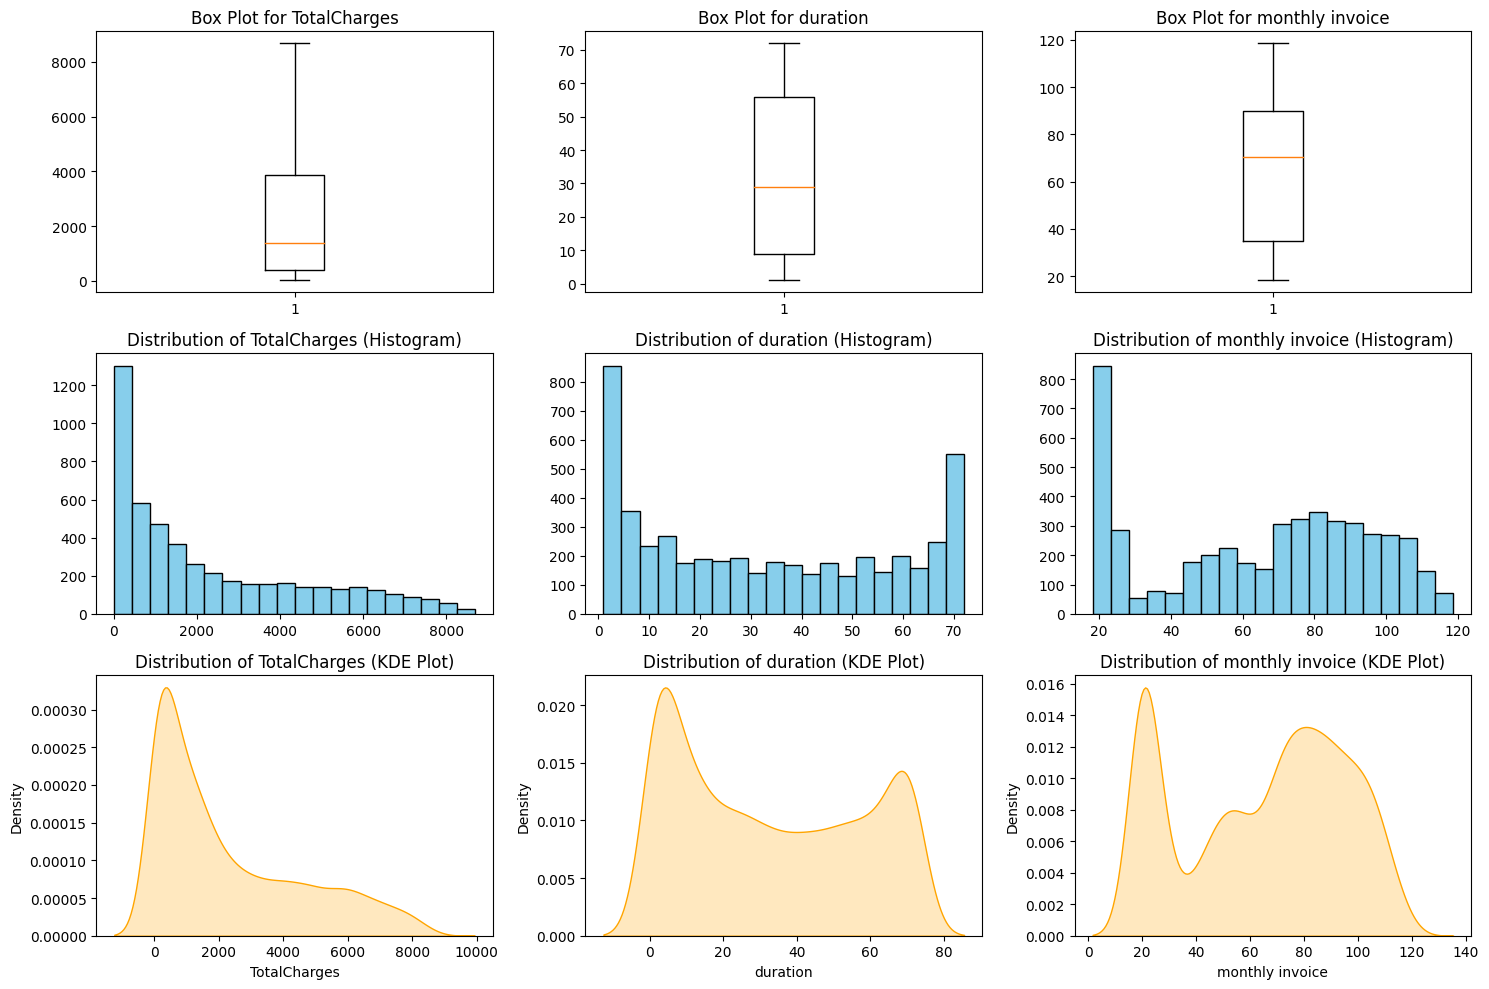

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'TotalCharges' to numeric from float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Create a 3 by 3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

axs = axs.flatten()

# Plot box plots
axs[0].boxplot(df['TotalCharges'].dropna())
axs[1].boxplot(df['duration'])
axs[2].boxplot(df['monthly invoice'])

# Plot histograms
axs[3].hist(df['TotalCharges'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[4].hist(df['duration'], bins=20, color='skyblue', edgecolor='black')
axs[5].hist(df['monthly invoice'], bins=20, color='skyblue', edgecolor='black')

# Plot KDE plots
sns.kdeplot(df['TotalCharges'].dropna(), ax=axs[6], color='orange', fill=True)
sns.kdeplot(df['duration'], ax=axs[7], color='orange', fill=True)
sns.kdeplot(df['monthly invoice'], ax=axs[8], color='orange', fill=True)

# Set titles for each subplot
axs[0].set_title('Box Plot for TotalCharges')
axs[1].set_title('Box Plot for duration')
axs[2].set_title('Box Plot for monthly invoice')
axs[3].set_title('Distribution of TotalCharges (Histogram)')
axs[4].set_title('Distribution of duration (Histogram)')
axs[5].set_title('Distribution of monthly invoice (Histogram)')
axs[6].set_title('Distribution of TotalCharges (KDE Plot)')
axs[7].set_title('Distribution of duration (KDE Plot)')
axs[8].set_title('Distribution of monthly invoice (KDE Plot)')

# Adjust to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()


### Observations:

1. None of these numerical continuous fields follow a normal distribution.
2. TotalCharges follows an approximate log-normal pattern, whereas the others are normally distributed.
3. Let us observe the distributions for customers who are at risk.

## Risk vs Non Risk - Class Wise Distributions of Numerical Fields

In [13]:
#Separating all at risk and non risk customers so that we can check class wise distributions

df_risk = df.loc[df['At risk'] == 'Yes']

df_norisk = df.loc[df['At risk'] == 'No']

### Distribution for At Risk customers

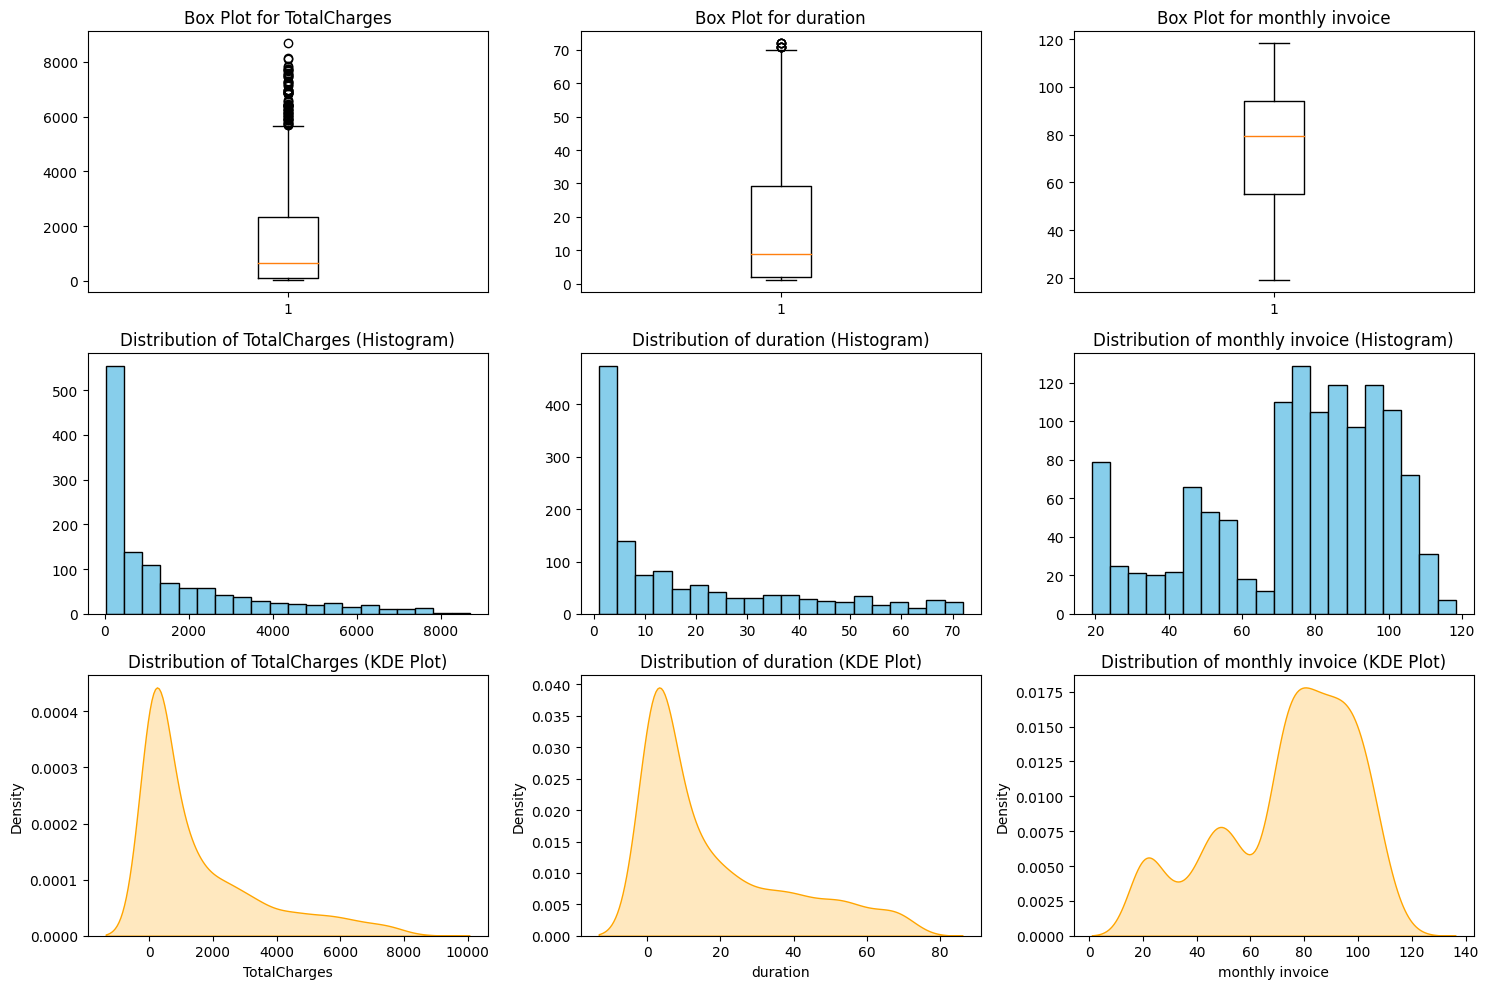

In [14]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

df_risk['TotalCharges'] = pd.to_numeric(df_risk['TotalCharges'], errors='coerce')

#3 by 3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

axs = axs.flatten()

# Plot box plots
axs[0].boxplot(df_risk['TotalCharges'].dropna())
axs[1].boxplot(df_risk['duration'])
axs[2].boxplot(df_risk['monthly invoice'])

# Plot histograms
axs[3].hist(df_risk['TotalCharges'].dropna(), bins=20, color='skyblue', edgecolor='black')
axs[4].hist(df_risk['duration'], bins=20, color='skyblue', edgecolor='black')
axs[5].hist(df_risk['monthly invoice'], bins=20, color='skyblue', edgecolor='black')

# Plot KDE plots
sns.kdeplot(df_risk['TotalCharges'].dropna(), ax=axs[6], color='orange', fill=True)
sns.kdeplot(df_risk['duration'], ax=axs[7], color='orange', fill=True)
sns.kdeplot(df_risk['monthly invoice'], ax=axs[8], color='orange', fill=True)

# titles for each subplot
axs[0].set_title('Box Plot for TotalCharges')
axs[1].set_title('Box Plot for duration')
axs[2].set_title('Box Plot for monthly invoice')
axs[3].set_title('Distribution of TotalCharges (Histogram)')
axs[4].set_title('Distribution of duration (Histogram)')
axs[5].set_title('Distribution of monthly invoice (Histogram)')
axs[6].set_title('Distribution of TotalCharges (KDE Plot)')
axs[7].set_title('Distribution of duration (KDE Plot)')
axs[8].set_title('Distribution of monthly invoice (KDE Plot)')

# Adjust to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()



### Observations

1. When isolating at risk customers, the distributions change significantly.
2. Customers with total charges within the range 0-2000, duration within 0-20, and monthly invoice within 70-110 pose the maximum risk.
3. We observe that most at risk customers have total charges < 6000, even though we have some outliers above the 8000 band.

## EDA of Categorical Fields

In [16]:
#separating categorical fields
cat_feat = ['Sex', 'Hasaspouse', 'Reliesuponsomeone', 'Youtube TV', 'Multiple Screens', 
            'Music Service', 'Hasmorethan3Playlists', 'Followsmorethan5artists', 'Haslistenedtomorethan5audiobooks',
           'TechSupport', 'Listens Podcast', 'Listens Music', 'subscription type', 'online invoice',
           'type of payment']

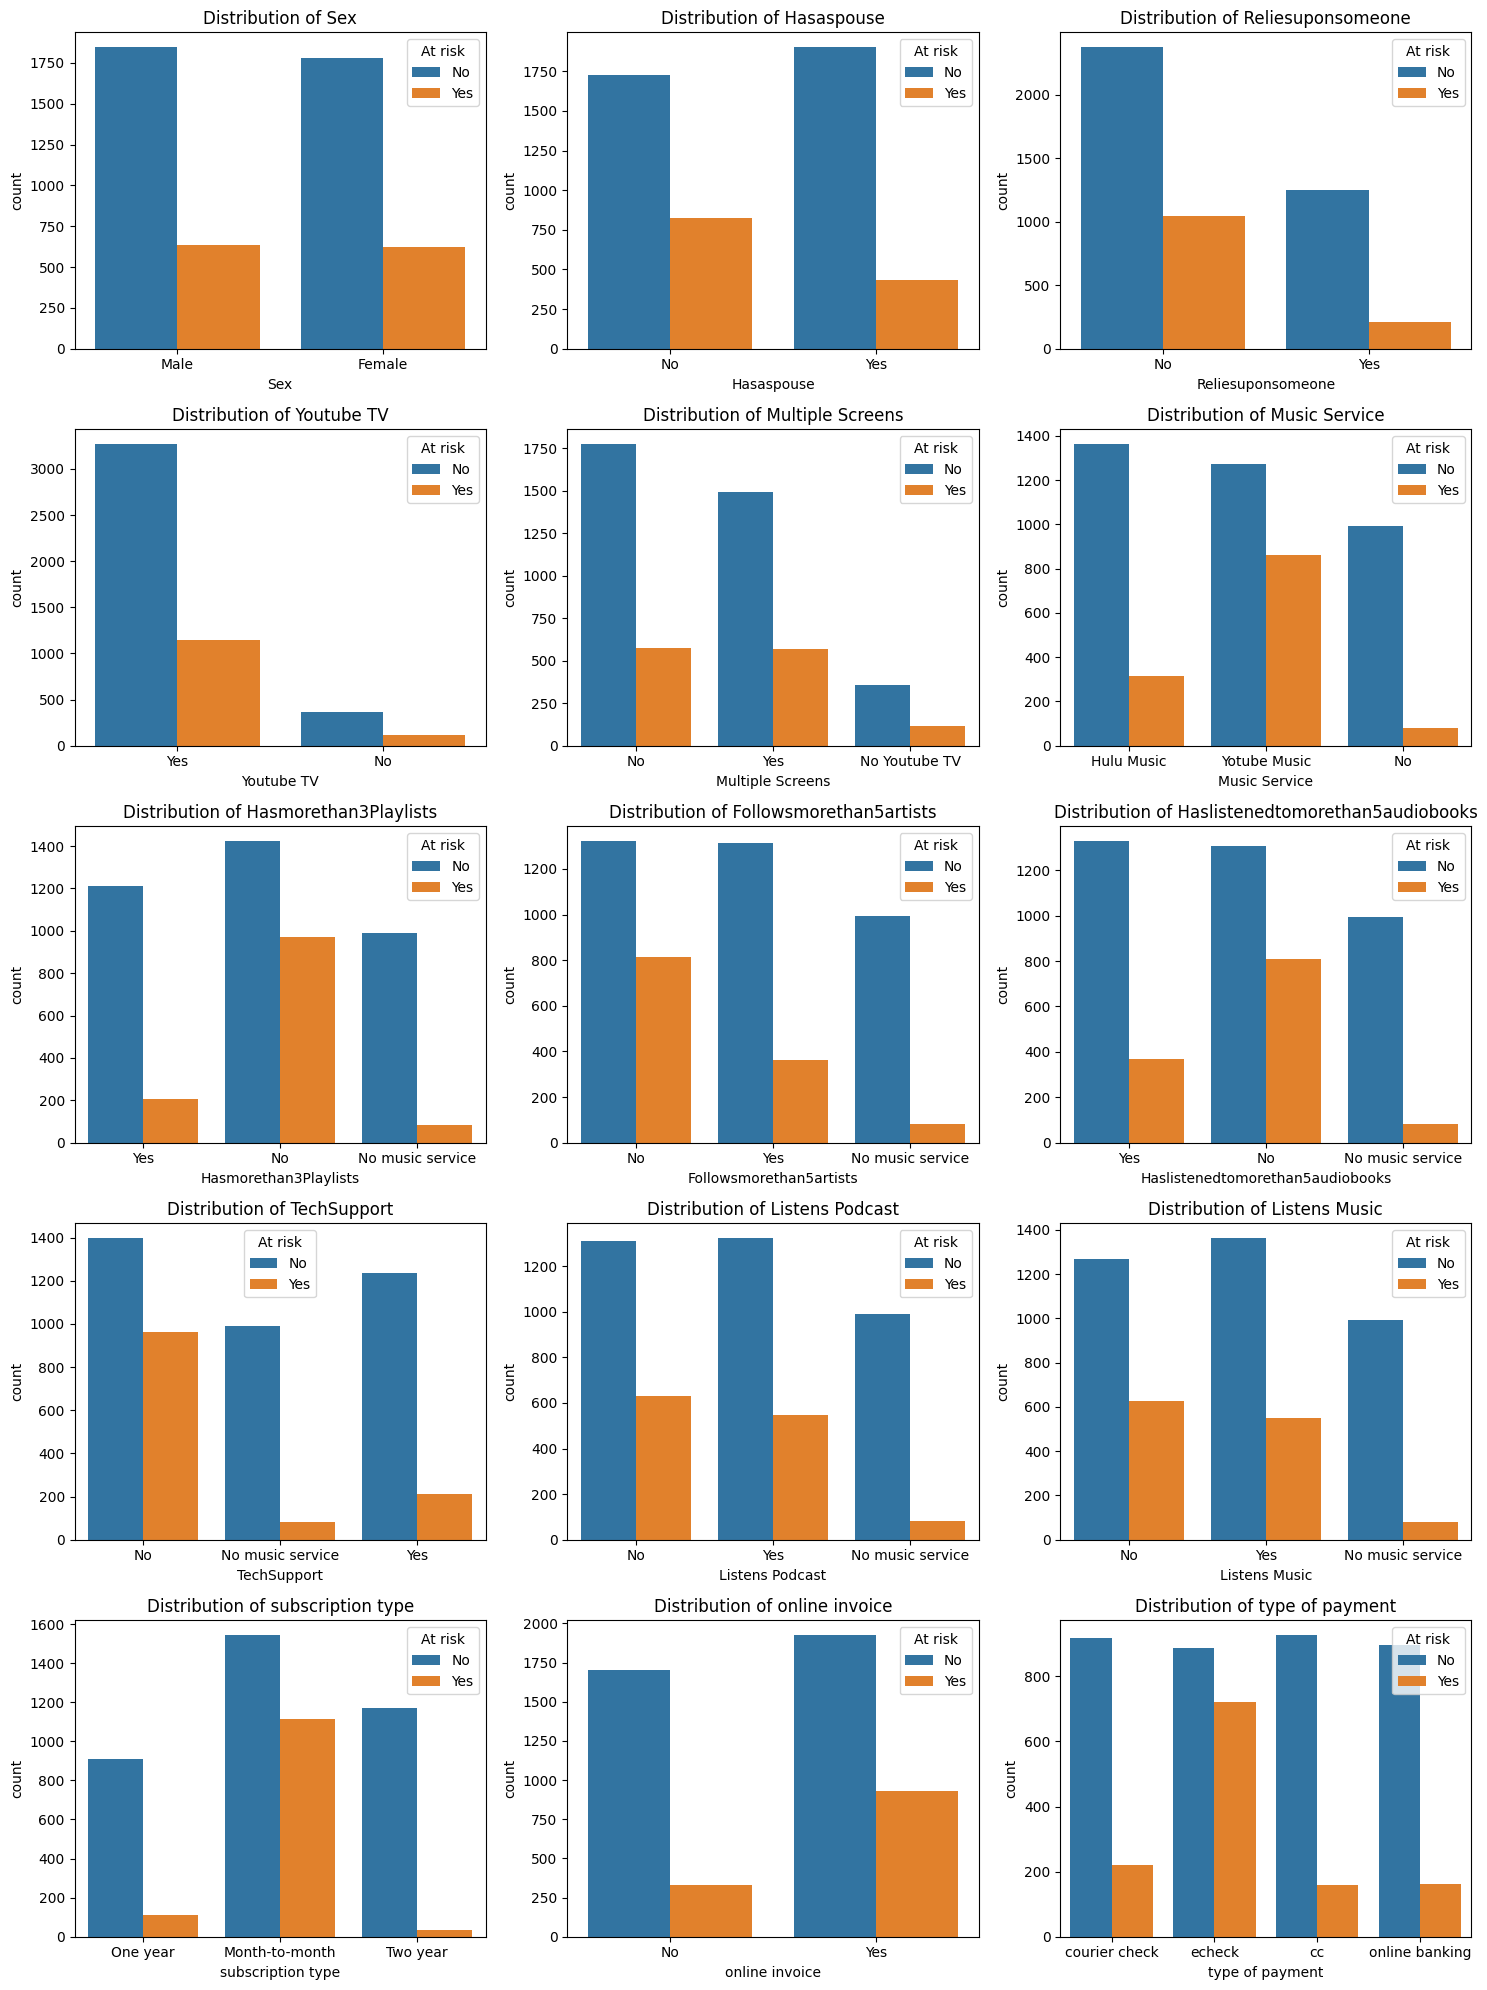

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 3, figsize=(15, 20))

# Flatten the axs array to simplify indexing
axs = axs.flatten()

for i, feature in enumerate(cat_feat):
    sns.countplot(x=feature, hue='At risk', data=df, ax=axs[i])
    axs[i].set_title(f'Distribution of {feature}')


plt.tight_layout()

plt.show()

### Observations

1. No observed differentiation in terms of sex.
2. For music service, a stark difference is observed for YouTube Music, as availers of this service demonstrate a significantly higher level of risk.
3. Customers with less than 3 playlists, and customers who have listened to less than 5 podcasts also demonstrate a very similar pattern as they demonstrate a significantly higher level of risk.
4. Customers who don't opt for tech support are at a high risk level.
5. Customers who opt for month to month subscription types are at a high risk level.
6. Customers who opt for 'echeck' as their preferred mode of payment are at a high risk level.

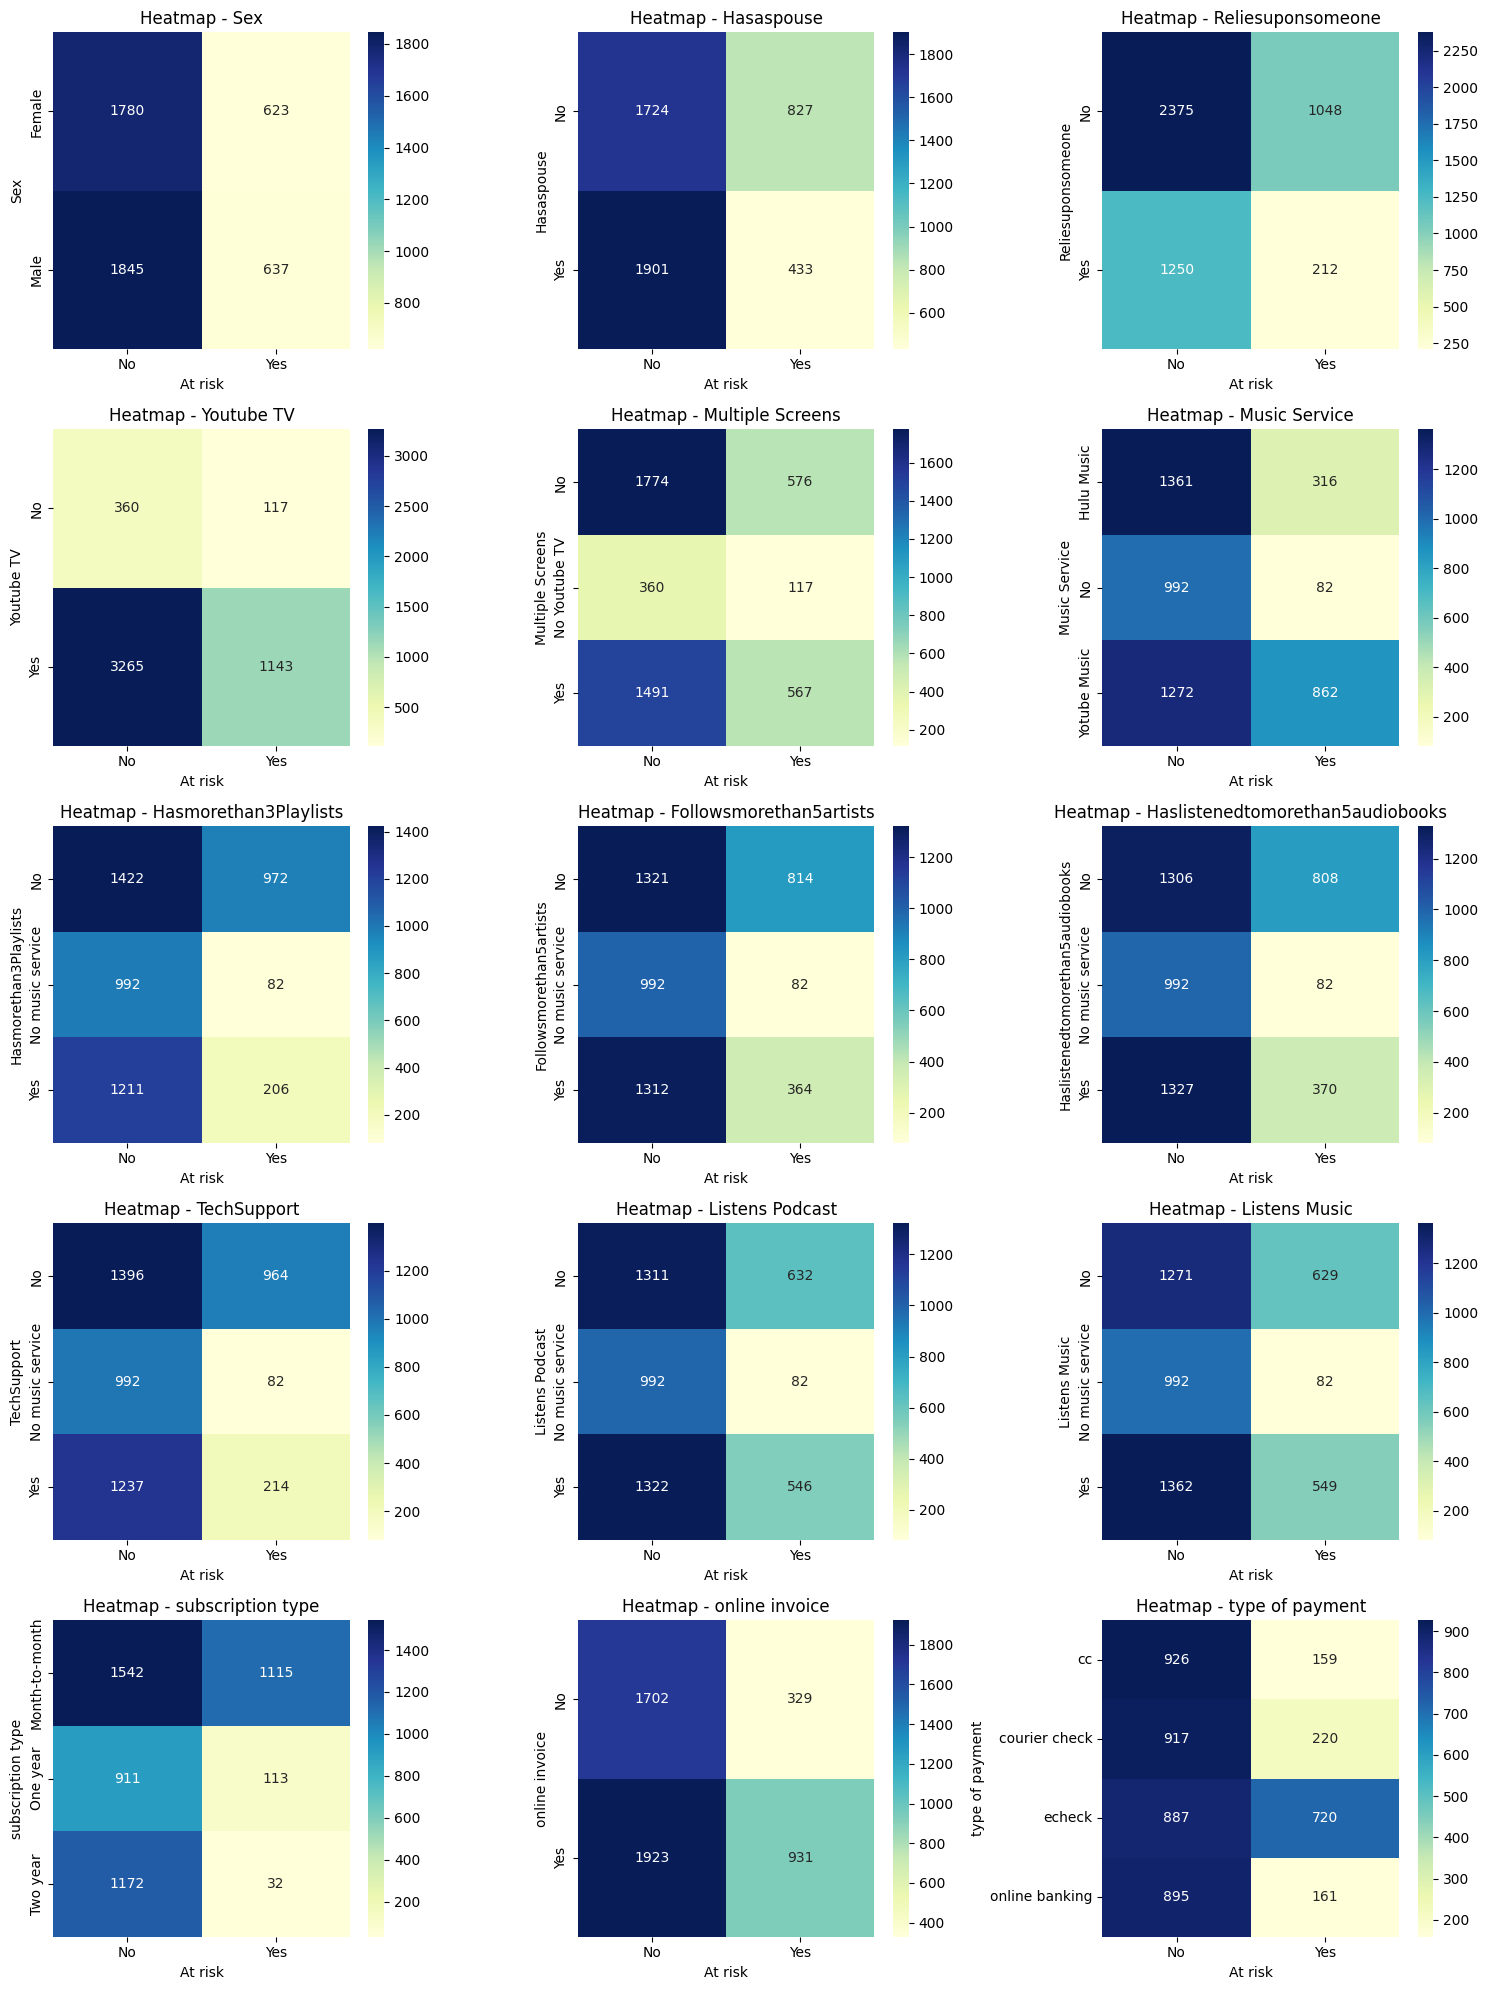

In [18]:
fig, axs = plt.subplots(5, 3, figsize=(15, 20))

axs = axs.flatten()

for i, feature in enumerate(cat_feat):
    crosstab_result = pd.crosstab(df[feature], df['At risk'])
    sns.heatmap(crosstab_result, annot=True, cmap='YlGnBu', fmt='g', ax=axs[i])
    axs[i].set_title(f'Heatmap - {feature}')

plt.tight_layout()

plt.show()


### Observations

The heat maps mirror the observations from our bar charts, but where the bar charts give us a a visual measure, the heat maps provide a more quantitative view.

## Feature Engineering

### Encoding target variable

In [19]:
#Encoding target variable 'At risk' with 0 or 1

df['At risk'] = df['At risk'].replace({'Yes':1, 'No':0})

In [20]:
# Find index of 'At risk' column
idx=df.columns.get_loc('At risk')

# Move the 'At risk' column to the end of the DataFrame
cols = list(df.columns)
cols.append(cols.pop(idx))
df = df[cols]

df.head()

,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,type of payment,At risk
0,Male,0,No,No,34,Yes,No,Hulu Music,Yes,No,Yes,No,No,No,One year,No,56.95,1889.50,courier check,0
1,Male,0,No,No,2,Yes,No,Hulu Music,Yes,Yes,No,No,No,No,Month-to-month,Yes,53.85,108.15,courier check,1
2,Female,0,No,No,2,Yes,No,Yotube Music,No,No,No,No,No,No,Month-to-month,Yes,70.70,151.65,echeck,1
3,Female,0,No,No,8,Yes,Yes,Yotube Music,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,99.65,820.50,echeck,1
4,Male,0,No,Yes,22,Yes,Yes,Yotube Music,No,Yes,No,No,Yes,No,Month-to-month,Yes,89.10,1949.40,cc,0


In [21]:
df.head()

,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,type of payment,At risk
0,Male,0,No,No,34,Yes,No,Hulu Music,Yes,No,Yes,No,No,No,One year,No,56.95,1889.50,courier check,0
1,Male,0,No,No,2,Yes,No,Hulu Music,Yes,Yes,No,No,No,No,Month-to-month,Yes,53.85,108.15,courier check,1
2,Female,0,No,No,2,Yes,No,Yotube Music,No,No,No,No,No,No,Month-to-month,Yes,70.70,151.65,echeck,1
3,Female,0,No,No,8,Yes,Yes,Yotube Music,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,99.65,820.50,echeck,1
4,Male,0,No,Yes,22,Yes,Yes,Yotube Music,No,Yes,No,No,Yes,No,Month-to-month,Yes,89.10,1949.40,cc,0


In [22]:
#creating a duplicate master df

df_master = df

### Train-Test Split before Encoding and Normalization to prevent Leakage

In [23]:
#Split the data into 70% training, 15% testing, and 15% validation sets

#Splitting the datset into 2 random sets in the ratio 70:30, the first returned set is the training set
df_train, temp_data, df_train_target, temp_target = train_test_split(df.iloc[:,:], df.iloc[:,-1], test_size=0.3, random_state=42)

#Splitting the second returned set into 2 random sets in the ratio 50:50, to get test and validation sets
df_test, df_valid, df_test_target, df_valid_target = train_test_split(temp_data, temp_target, test_size=0.5, random_state=42)

# Print the size of each set
print("Train set size: ", len(df_train))
print("Test set size: ", len(df_test))
print("Validation set size: ", len(df_valid))

Train set size:  3419
Test set size:  733
Validation set size:  733


### Encoding nominal categorial variables
We will perform target encoding of the nominal categorical variables based on the value of target variable. For this, we will define a function first.

In [24]:
#function for target encoding
def target_encoding(df, col, target_col):
  prob_risk= df.groupby(col)[target_col].mean() # Calculate the probability of risk for each category
  prob_dict = prob_risk.to_dict()   # Create a dictionary mapping each category to its probability ratio
  df[col] = df[col].map(prob_dict)  # Replace the original categorical variable with its probability ratio encoding
  return df

In [25]:
#Train set

#target encoding of all categorical fields
for col in cat_feat:
  df_train = target_encoding(df_train, col, 'At risk')

df_train = df_train.drop('At risk', axis = 1)
df_train.head()

,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,type of payment
2668,0.25,1,0.19,0.30,25,0.26,0.28,0.41,0.15,0.38,0.37,0.40,0.31,0.29,0.11,0.32,89.05,2177.45,0.45
2542,0.25,0,0.19,0.14,71,0.26,0.28,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.03,0.16,25.35,1847.55,0.15
4313,0.25,0,0.32,0.30,29,0.24,0.24,0.18,0.40,0.38,0.37,0.40,0.31,0.33,0.11,0.32,24.85,788.05,0.18
1076,0.25,0,0.32,0.30,30,0.26,0.23,0.41,0.40,0.38,0.37,0.40,0.30,0.29,0.41,0.32,90.25,2755.35,0.45
2748,0.26,0,0.32,0.30,9,0.24,0.24,0.18,0.15,0.38,0.22,0.16,0.30,0.29,0.41,0.16,58.50,539.85,0.18


In [26]:
#Test set

#target encoding of all categorical fields
for col in cat_feat:
  df_test = target_encoding(df_test, col, 'At risk')

df_test = df_test.drop('At risk', axis = 1)
df_test.head()

,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,type of payment
2957,0.27,0,0.16,0.11,68,0.26,0.27,0.38,0.14,0.21,0.15,0.43,0.27,0.29,0.01,0.34,110.20,7467.50,0.46
1962,0.26,0,0.36,0.33,66,0.26,0.25,0.21,0.14,0.21,0.15,0.43,0.35,0.33,0.01,0.34,61.15,4017.45,0.16
1188,0.27,0,0.16,0.11,35,0.26,0.27,0.38,0.40,0.21,0.42,0.43,0.27,0.33,0.44,0.34,89.65,3161.60,0.16
3228,0.27,0,0.36,0.33,2,0.26,0.25,0.38,0.40,0.40,0.42,0.43,0.35,0.33,0.44,0.34,70.30,144.00,0.46
596,0.26,0,0.16,0.33,56,0.26,0.25,0.38,0.14,0.21,0.15,0.43,0.27,0.29,0.10,0.34,105.60,6068.65,0.13


In [27]:
#Validation set

#target encoding of all categorical fields
for col in cat_feat:
  df_valid = target_encoding(df_valid, col, 'At risk')

df_valid = df_valid.drop('At risk', axis = 1)
df_valid.head()



,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,type of payment
156,0.24,0,0.33,0.31,72,0.27,0.29,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.03,0.17,20.25,1566.90,0.15
2623,0.29,0,0.20,0.31,72,0.27,0.25,0.41,0.14,0.38,0.26,0.14,0.27,0.28,0.03,0.33,110.90,8240.85,0.15
748,0.24,0,0.33,0.31,50,0.27,0.25,0.20,0.14,0.38,0.26,0.14,0.27,0.28,0.11,0.33,82.50,4179.10,0.15
499,0.24,0,0.20,0.18,72,0.27,0.25,0.41,0.14,0.24,0.37,0.14,0.36,0.35,0.03,0.33,90.35,6563.40,0.15
4214,0.24,0,0.33,0.18,12,0.27,0.29,0.20,0.42,0.38,0.37,0.43,0.36,0.35,0.43,0.33,44.55,480.60,0.44


### Normalization (min-max scaling) of continuous numerical fields 

Observing the distribution of the 3 continuous numerical fields - TotalCharges, duration and monthly invoice, we find none of them resemble a Gaussian distribution. In such cases, normalisation does a better job than standardisation, so we will normalise these fields. Also, normalisation is more sensitive to outliers and preserves the shape of the original distribution.

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of columns to be scaled
columns_to_scale = ['TotalCharges', 'duration', 'monthly invoice']

# Fit and transform the training dataset
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])

# Transform the test dataset using the scaler fitted on the training dataset
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

# Transform the validation dataset using the scaler fitted on the training dataset
df_valid[columns_to_scale] = scaler.transform(df_valid[columns_to_scale])


df_valid.head()

## Building the Models

We will use two approaches. We will first use a random forest classifier, as the dataset is not very large and RF classifiers work better with smaller sets. As an alternative approach, we will use a deep learning model (using neural networks) and compare the performance. These models work better with larget datasets as the model gets to learn more, so it will be interesting to see how it performs for a smaller dataset.



### First Approach - Random Forest Classifier

Accuracy: 0.8130968622100955
F1 Score: 0.8083042924918922
Precision: 0.8061362719289819
Recall: 0.8130968622100955


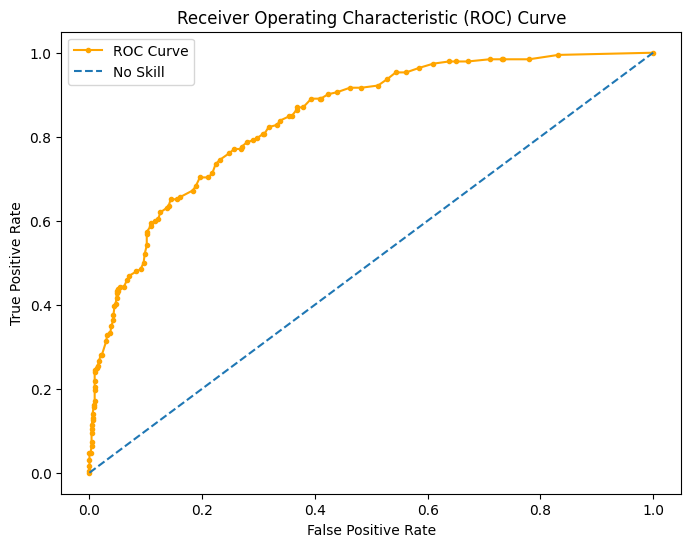

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
 
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
 
# Train the classifier on the training data
rf_classifier.fit(df_train, df_train_target)
 
# Make predictions on the testing data
y_pred = rf_classifier.predict(df_test)
 
# Calculate the accuracy of the classifier
accuracy = accuracy_score(df_test_target, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(df_test_target, y_pred, average='weighted')
print("F1 Score:", f1)
 
# Calculate precision
precision = precision_score(df_test_target, y_pred, average='weighted')
print("Precision:", precision)
 
# Calculate recall
recall = recall_score(df_test_target, y_pred, average='weighted')
print("Recall:", recall)
 
# Calculate ROC curve
y_probs = rf_classifier.predict_proba(df_test)
fpr, tpr, thresholds = roc_curve(df_test_target, y_probs[:, 1])
 
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC Curve', color = 'orange')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

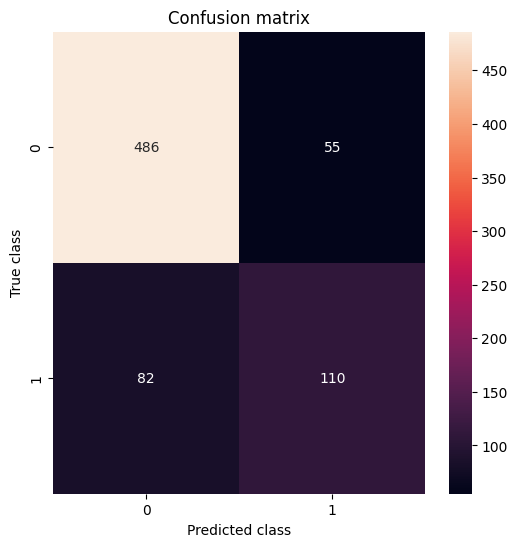

In [72]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

test_x_predictions = y_pred

conf_matrix = confusion_matrix(df_test_target, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


### Feature Importance - Random Forest Model

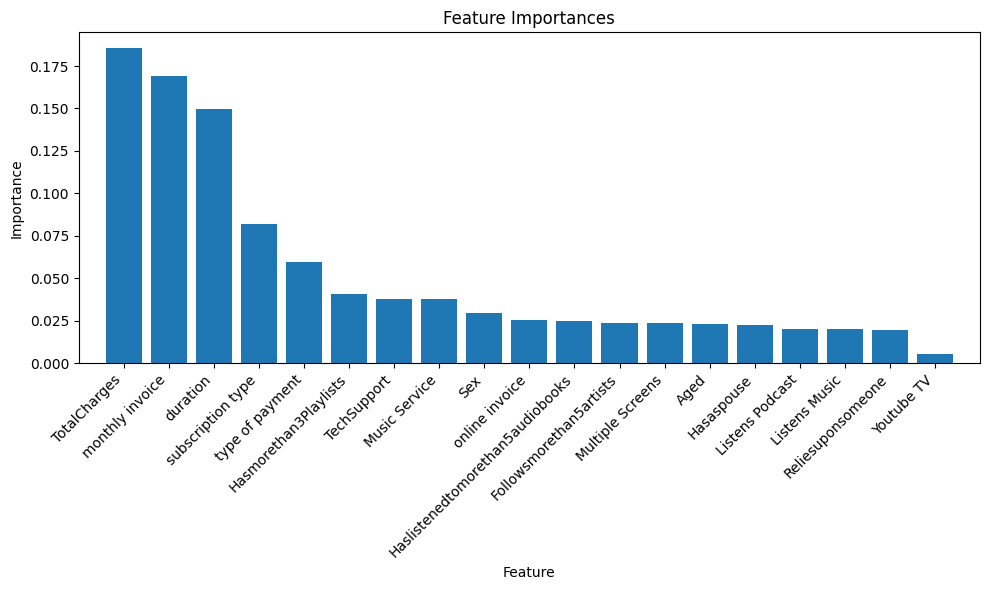

In [55]:
# Import necessary libraries

import numpy as np

import matplotlib.pyplot as plt
 
# Extract feature importances

importances = rf_classifier.feature_importances_
 
# Get the indices of features sorted by importance

indices = np.argsort(importances)[::-1]
 
# Rearrange feature names based on importance

feature_names = df_train.columns
 
# Plot the feature importances

plt.figure(figsize=(10, 6))

plt.title("Feature Importances")

plt.bar(range(df_train.shape[1]), importances[indices], align="center")

plt.xticks(range(df_train.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')

plt.xlim([-1, df_train.shape[1]])

plt.xlabel("Feature")

plt.ylabel("Importance")

plt.tight_layout()

plt.show()



Analysis of the features reveals that in terms of importance - TotalCharges, monthly invoice and duration are the 3 most important features. This is in line with our EDA effort where we observed that distributions for these 3 variables differed significantly for the At Risk vs Non risk classes.

### Second Approach - Neural Network Classifier

We will build a sequential neural network classifier, where layers can be added one by one in a linear stack.

Points to note:
1. Input layer - Dense (fully connected) layer with 100 units, using the ReLU (Rectified Linear Unit) activation function. The input_shape parameter is set to (input_dim), where input_dim is the number of features in the input data.
2. First dropout layer - Dropout rate of 0.2. Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
3. Hidden layer - Another dense layer with 20 units and ReLU activation.
4. Second dropout layer - Another dropout layer with a dropout rate of 0.2.
5. Output layer - Single unit with sigmoid activation function. This is suitable for binary classification tasks, where the output represents the probability of the positive (At risk = Yes) class.
6. We will employ the 'adam' optimizer function, and for the loss function we will use 'binary_crossentropy'.

In [30]:
#pip install tensorflow
import tensorflow as tf

In [73]:
nb_epoch = 80
batch_size = 256
input_dim = df_train.shape[1] #num of predictor variables
learning_rate = 0.0001

#Initialising Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, input_shape=(input_dim,), activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=20,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
#Adding Output Layer
model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

#Compiling Model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss="binary_crossentropy",metrics=[tf.keras.metrics.Recall()])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),loss=weighted_binary_crossentropy, metrics = ['accuracy'])

class_weight = {0:1.,1:5.}
#Fitting Model
model.fit(df_train, df_train_target,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    class_weight = class_weight,
                    validation_data=(df_valid, df_valid_target)
          )

Epoch 1/80
14/14 [==============================] - 0s 5ms/step - loss: 1.3512 - recall_3: 0.9289 - val_loss: 0.7585 - val_recall_3: 1.0000
Epoch 2/80
14/14 [==============================] - 0s 2ms/step - loss: 1.3279 - recall_3: 0.9713 - val_loss: 0.7685 - val_recall_3: 1.0000
Epoch 3/80
14/14 [==============================] - 0s 2ms/step - loss: 1.3116 - recall_3: 0.9839 - val_loss: 0.7775 - val_recall_3: 1.0000
Epoch 4/80
14/14 [==============================] - 0s 2ms/step - loss: 1.3019 - recall_3: 0.9931 - val_loss: 0.7837 - val_recall_3: 1.0000
Epoch 5/80
14/14 [==============================] - 0s 2ms/step - loss: 1.2889 - recall_3: 0.9954 - val_loss: 0.7898 - val_recall_3: 1.0000
Epoch 6/80
14/14 [==============================] - 0s 1ms/step - loss: 1.2784 - recall_3: 1.0000 - val_loss: 0.7929 - val_recall_3: 1.0000
Epoch 7/80
14/14 [==============================] - 0s 1ms/step - loss: 1.2739 - recall_3: 0.9966 - val_loss: 0.7953 - val_recall_3: 1.0000
Epoch 8/80
14/14 [==

14/14 [==============================] - 0s 1ms/step - loss: 1.0057 - recall_3: 0.8876 - val_loss: 0.6537 - val_recall_3: 0.9082
Epoch 60/80
14/14 [==============================] - 0s 1ms/step - loss: 1.0025 - recall_3: 0.8681 - val_loss: 0.6548 - val_recall_3: 0.9082
Epoch 61/80
14/14 [==============================] - 0s 1ms/step - loss: 1.0084 - recall_3: 0.8830 - val_loss: 0.6482 - val_recall_3: 0.9082
Epoch 62/80
14/14 [==============================] - 0s 1ms/step - loss: 0.9954 - recall_3: 0.8681 - val_loss: 0.6453 - val_recall_3: 0.9082
Epoch 63/80
14/14 [==============================] - 0s 1ms/step - loss: 1.0059 - recall_3: 0.8773 - val_loss: 0.6431 - val_recall_3: 0.9031
Epoch 64/80
14/14 [==============================] - 0s 1ms/step - loss: 0.9972 - recall_3: 0.8681 - val_loss: 0.6481 - val_recall_3: 0.9082
Epoch 65/80
14/14 [==============================] - 0s 1ms/step - loss: 0.9918 - recall_3: 0.8727 - val_loss: 0.6493 - val_recall_3: 0.9082
Epoch 66/80
14/14 [======

### ROC Curve

23/23 [==============================] - 0s 433us/step
Best Threshold=0.762541, G-Mean=0.766


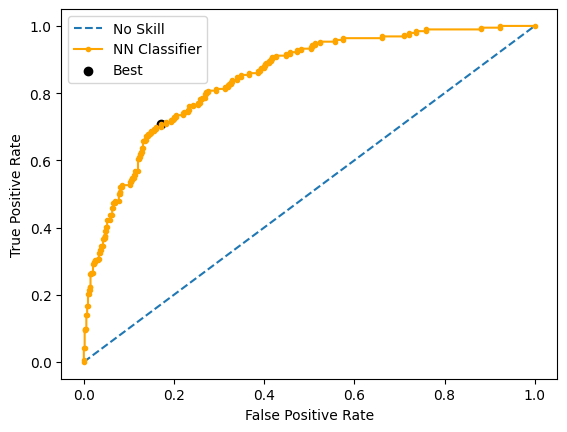

In [74]:
from numpy import argmax
from numpy import sqrt
from sklearn.metrics import roc_curve

test_x_predictions = model.predict(df_test)

# calculate roc curves
fpr, tpr, thresholds = roc_curve(df_test_target, test_x_predictions)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='NN Classifier', color = 'orange')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Here we calculate the ROC curve and identify the threshold that maximizes the geometric mean (G-mean) of sensitivity and specificity. Then the ROC curve is plotted, marking the operating point associated with the best G-mean. The black dot on the ROC curve represents the point corresponding to the best threshold.

Sensitivity= True Positives/(True Positives + False Negatives) || 
Specificity= True Negatives/(True Negatives + False Positives)

### Precision-Recall Curve

23/23 [==============================] - 0s 608us/step
Best Threshold=0.794167, F-Score=0.652


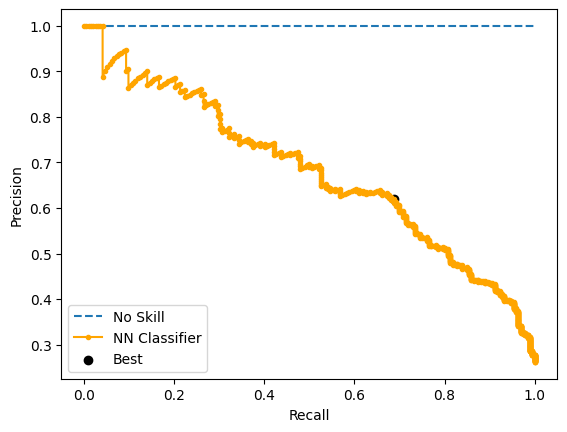

In [75]:
from sklearn.metrics import precision_recall_curve

test_x_predictions = model.predict(df_test)

# calculate pr curve
precision, recall, thresholds = precision_recall_curve(df_test_target, test_x_predictions)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(df_test_target[df_test_target==1]) / len(df_test_target)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='NN Classifier', color = 'orange')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Here we calculate the Precision-Recall curve and identify the threshold that maximizes the F-score. Then we plot the Precision-Recall curve, marking the operating point associated with the best F-score. The black dot on the PR curve represents the point corresponding to the best threshold.

### Predictions

23/23 [==============================] - 0s 535us/step


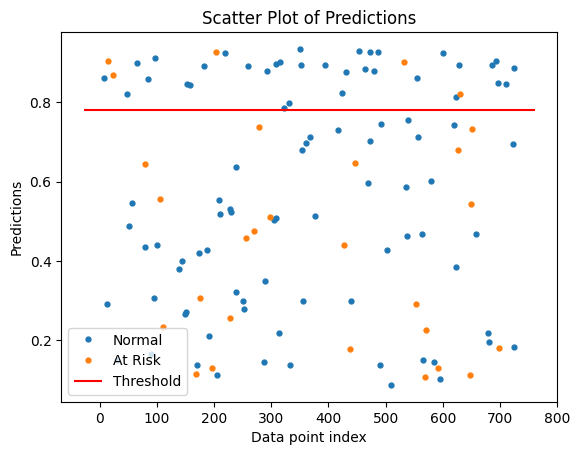

In [78]:
test_x_predictions = model.predict(df_test)
test_x_predictions=pd.DataFrame(test_x_predictions, columns=['pred'])
df_test_target=pd.DataFrame(df_test_target, columns=['At risk'])
error_df_test = pd.DataFrame({'Pred': test_x_predictions['pred'],
                        'True_class': df_test_target['At risk']})
error_df_test = error_df_test.reset_index()

threshold_fixed = 0.78
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Pred, marker='o', ms=3.5, linestyle='',
            label= "At Risk" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Scatter Plot of Predictions")
plt.ylabel("Predictions")
plt.xlabel("Data point index")
plt.show();

23/23 [==============================] - 0s 546us/step


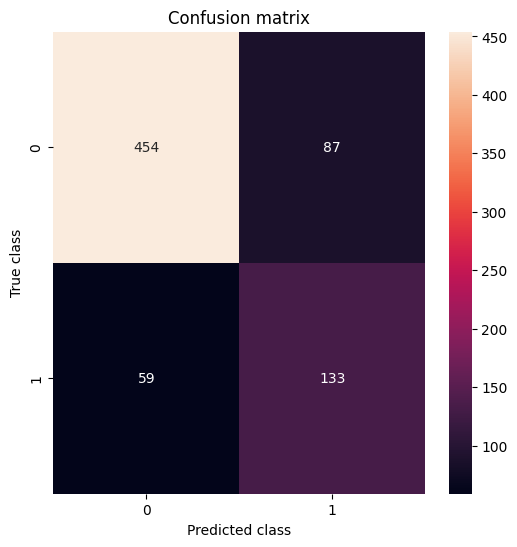

F1 score: 0.645631067961165
Recall: 0.6927083333333334
Accuracy: 0.800818553888131
Precision: 0.6045454545454545


In [77]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

test_x_predictions = model.predict(df_test)
threshold_fixed = 0.78
pred_y = [1 if e > threshold_fixed else 0 for e in test_x_predictions]
conf_matrix = confusion_matrix(df_test_target, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print('F1 score:', f1_score(df_test_target, pred_y))
print('Recall:', recall_score(df_test_target, pred_y))
print('Accuracy:', accuracy_score(df_test_target, pred_y))
print('Precision:', precision_score(df_test_target, pred_y))


### Observations

As expected, the random forest classifier outperforms the neural network classifier mainly because of the relatively small size of the dataset. With larger datasets, we can expect a different result.

### Assessing Feature Importance of a Deep Learning Model using LIME (Local Interpretable Model Agnostic Explanation)

In [36]:
#pip install lime
import lime
from lime import lime_tabular


In [116]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(df_train),
    feature_names=df_train.columns,
    class_names=['No Risk', 'At Risk'],
    categorical_features=list([0,2,3,5,6,7,8,9,10,11,12,13,14,15,18]),
    mode='classification'
)

In [92]:
def prob(data):
  preds = model.predict(data)
  preds_p = np.ravel(preds)
  preds_n = 1-preds
  preds_n = np.ravel(preds_n)
  return np.array(list(zip(preds_n,preds_p)))

In [80]:
df_test.head()

,Sex,Aged,Hasaspouse,Reliesuponsomeone,duration,Youtube TV,Multiple Screens,Music Service,Hasmorethan3Playlists,Followsmorethan5artists,Haslistenedtomorethan5audiobooks,TechSupport,Listens Podcast,Listens Music,subscription type,online invoice,monthly invoice,TotalCharges,type of payment
2957,0.27,0,0.16,0.11,0.94,0.26,0.27,0.38,0.14,0.21,0.15,0.43,0.27,0.29,0.01,0.34,0.92,0.86,0.46
1962,0.26,0,0.36,0.33,0.92,0.26,0.25,0.21,0.14,0.21,0.15,0.43,0.35,0.33,0.01,0.34,0.43,0.46,0.16
1188,0.27,0,0.16,0.11,0.48,0.26,0.27,0.38,0.40,0.21,0.42,0.43,0.27,0.33,0.44,0.34,0.71,0.36,0.16
3228,0.27,0,0.36,0.33,0.01,0.26,0.25,0.38,0.40,0.40,0.42,0.43,0.35,0.33,0.44,0.34,0.52,0.01,0.46
596,0.26,0,0.16,0.33,0.77,0.26,0.25,0.38,0.14,0.21,0.15,0.43,0.27,0.29,0.10,0.34,0.87,0.70,0.13


In [121]:
  exp = explainer.explain_instance(
    data_row=df_test.iloc[9], 
    predict_fn=prob
)

exp.show_in_notebook(show_table=True, show_all=False)

157/157 [==============================] - 0s 621us/step


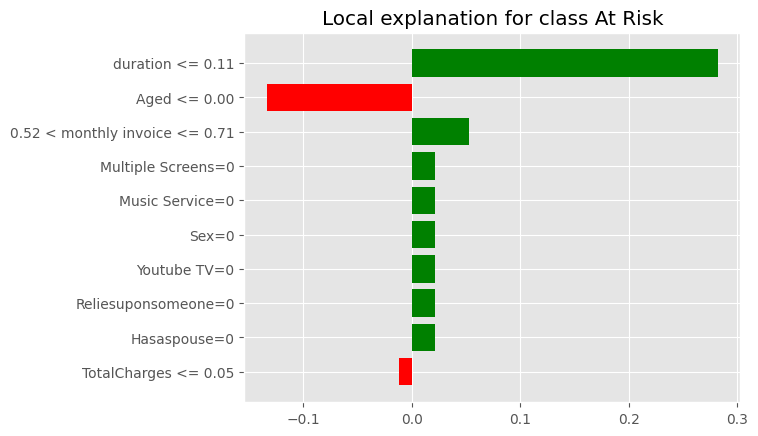

In [122]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()